# Problema de Negócio

**All in One** é uma empresa fictícia de comércio eletrônico com sede no Reino Unido. Ela oferece uma ampla gama de produtos voltados para diversas categorias, incluindo decoração de casa, suprimentos para festas, acessórios de cozinha, soluções de armazenamento e muito mais.

Após vender com sucesso uma ampla variedade de produtos e acumular uma base substancial de clientes, a All in One reconhece o imenso valor oculto em seus dados de clientes. A empresa tem como objetivo aproveitar o poder da ciência de dados para obter **insights mais profundos** sobre sua base de clientes e aplicar esses insights de forma estratégica. Um de seus principais objetivos é **segmentar seus clientes** de forma eficaz. Essa segmentação permitirá à All in One compreender sua base de clientes em um nível mais detalhado, identificar grupos de clientes específicos com necessidades e preferências distintas, e adaptar seus esforços de marketing e ofertas de produtos de acordo.

Além disso, ao implementar um **programa de fidelidade**, a All in One busca cultivar relacionamentos mais fortes com os clientes e aumentar a retenção deles. Por meio da análise cuidadosa dos comportamentos dos clientes, padrões de compra e preferências, eles podem projetar um programa de fidelidade que ofereça incentivos personalizados, recompensas e benefícios exclusivos para diferentes segmentos de clientes. Essa abordagem personalizada não apenas promove a fidelidade do cliente, mas também cria um senso de apreço e pertencimento entre os clientes, fortalecendo ainda mais sua conexão com a marca.

# Dados

- **InvoiceNo**: Número da fatura, um identificador único para cada transação
- **StockCode**: Código do produto, um identificador único para cada produto
- **Description**: Descrição do produto
- **Quantity**: Quantidade de produtos comprados em cada transação
- **InvoiceDate**: Data e hora de cada transação
- **UnitPrice**: Preço unitário de cada produto
- **CustomerID**: ID do cliente, um identificador único para cada cliente
- **Country**: País do cliente

# Planejamento da Solução

## Entrada

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para participar de um Programa de Fidelidade.
2. Conjunto de Dados:
    - Dados de vendas de uma plataforma de comércio eletrônico online, cobrindo um período de um ano.



## Saída

1. Identificação das pessoas a serem parte do programa Insiders
    - Lista:

    - client_id is_insiders
    - 10323 sim/1
    - 32413 não/0
2. Relatório com respostas para perguntas de negócios:
    - Quem são as pessoas elegíveis para participar do programa Insiders?
    - Quantos clientes serão incluídos no grupo?
    - Quais são as características-chave desses clientes?
    - Qual é a porcentagem de contribuição de receita dos Insiders?

## Tarefa

1. Quem são as pessoas elegíveis para participar do programa Insiders?
    - O que significa ser elegível? Quem são os clientes de alto valor?
    - Receita:
        - Ticket médio alto.
        - Alto valor vitalício do cliente (LTV).
        - Baixa recência.
        - Tamanho do cesto alto.
        - Baixa probabilidade de churn - modelos.
        - Alta previsão de LTV - modelos.
        - Alta propensão de compra - modelos.
2. Custo:
    - Baixa taxa de retorno.

3. Quantos clientes serão incluídos no grupo? - Número total de clientes - % do grupo Insiders

4. Quais são as características-chave desses clientes? - Escreva características dos clientes: - Idade - Localização - Escreva características de consumo: - Atributos de cluster.

5. Qual é a porcentagem de contribuição de receita dos Insiders? - Receita total do ano - Receita total do grupo Insiders durante o ano.

# 0.0 IMPORTS

In [1]:
import pandas   as pd
import numpy    as np
import seaborn  as sns
import inflection
import sweetviz as sv
import warnings
import re

from matplotlib import pyplot as plt
from plotly     import express    as px

from sklearn import cluster       as c
from sklearn import metrics       as mt
from sklearn import preprocessing as pp

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

warnings.filterwarnings('ignore')

C:\Users\edils\anaconda3\envs\customer_fidelity\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Functions

In [2]:
palette = ["#00BFFF", "#DC143C", "#FFA07A", "#FFD700", "#8B008B", "#7CFC00", "#FF69B4", "#00CED1", "#FF6347", "#9400D3"]
def jupyter_settings(palette):
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 50
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set(font_scale=2)
    sns.set_theme(palette=palette)
    warnings.simplefilter("ignore")
    # plt.rcParams.update({'font.size': 10})
    sns.set_style("white")

    
jupyter_settings(palette)   

## 0.2 Loading Data

In [3]:
path = 'C:/Users/edils/repos/customer_fidelity/data/'

In [4]:
df_raw = pd.read_csv(path + 'ecommerce.csv', encoding='windows-1252')

In [5]:
df_raw = df_raw.drop('Unnamed: 8', axis=1)

In [6]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 DATA DESCRIPTION

In [7]:
df1 = df_raw.copy()

In [8]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [9]:
# report = sv.analyze(df1)
# report.show_html()

## 1.1 Rename Columns

In [10]:
df1.columns = df1.columns.map(lambda x: inflection.underscore(x))

## 1.2 Data Dimensions

In [11]:
df1.shape

(541909, 8)

## 1.3 Data Types

In [12]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [13]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [14]:
#replace NA for invoice to recuperate data
df1['customer_id'] = df1.apply(lambda x: x['invoice_no'] if pd.isnull(x['customer_id']) else x['customer_id'], axis=1)

## 1.6 Change Types

In [15]:
#df1['customer_id'] = df1['customer_id'].astype('int64')

In [16]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

## 1.7 Descriptive Statistics

In [17]:
numerical_attributes = df1.select_dtypes(include=['float64', 'int64', 'datetime64[ns]'])
categorical_atributtes = df1.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]'])

## 1.7.1 Numerical Analysis

In [18]:
disp = numerical_attributes.agg(['mean','median','std','min','max',lambda x: max(x) - min(x), 'skew', 'kurtosis']).T.rename(columns={'<lambda>':'range'})

In [19]:
disp

,mean,median,std,min,max,range,skew,kurtosis
quantity,9.55225,3.0,218.081158,-80995.0,80995.0,161990.0,-0.264076,119769.160031
invoice_date,2017-07-02 00:00:13.073782016,2017-07-17 00:00:00,115 days 21:02:59.177457004,2016-11-29 00:00:00,2017-12-07 00:00:00,373 days 00:00:00,NaN,NaN
unit_price,4.611114,2.08,96.759853,-11062.06,38970.0,50032.06,186.506972,59005.719097


Podemos ver que existes dados grandes e negativos em 'quantity'e também produtos igual a 0.0 em unit_price

## 1.7.2 Categorical Atributtes

In [20]:
categorical_atributtes

,invoice_no,stock_code,description,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,17850.0,United Kingdom
...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,12680.0,France


In [21]:
#invoice_no
letter_lines = categorical_atributtes['invoice_no'].apply(lambda x: bool (re.search('[a-zA-Z]', x)))
letter_df = df1.loc[letter_lines,'quantity']
any(letter_df >0)

True

Todos os valores de invoice que começam com C tem valores de quantidade negativos, provavelmente são itens de devolução

In [22]:
#stock_code
stock_letter = categorical_atributtes['stock_code'].apply(lambda x: bool (re.search('^[a-zA-Z]+$', x)))
stock_df = df1.loc[stock_letter,:]

In [23]:
stock_df['stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

Na coluna stock_code temos vários itens com descrições diferentes que estão sujando o dataframe

In [24]:
#country - European Community and Unspecified
df1['country'].unique()
df1.loc[:,['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by='customer_id', ascending=False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


In [25]:
#remove description

# 2.0 VARIABLE FILTERING

In [26]:
df2 = df1.copy()

## 2.1 Numerical Attributes

In [27]:
#unit_price
df2 = df2.loc[df2['unit_price'] >= 0.040,:]

#stock code
df2 = df2.loc[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK']),:]

#description
df2 = df2.drop('description', axis=1)

#country
df2 = df2.loc[~df2['country'].isin(['Unspecified','European Community']),:]


In [28]:
#divide df in purchases and returns
df_purchase = df2.loc[df2['quantity'] >=0, :]
df_returns = df2.loc[df2['quantity'] < 0,:]

# 3.0 FEATURE ENGINEERING

In [29]:
df3 = df2.copy()

In [30]:
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,6,2016-11-29,3.39,17850.0,United Kingdom
2,536365,84406B,8,2016-11-29,2.75,17850.0,United Kingdom
3,536365,84029G,6,2016-11-29,3.39,17850.0,United Kingdom
4,536365,84029E,6,2016-11-29,3.39,17850.0,United Kingdom


In [31]:
#Criar features baseado no RFM Model - Recency, Frequency, Monetary

#Monetary - O quanto cada cliente gera de $
aux_monetary = pd.DataFrame()
aux_monetary['valor_bruto'] = df_purchase['quantity'] * df_purchase['unit_price']
aux_monetary['customer_id'] = df_purchase['customer_id']
df_ref = aux_monetary.loc[:,['valor_bruto', 'customer_id']].groupby('customer_id').sum().reset_index()


#Frequency - Quantas vezes o cliente comprou
aux_invoice = df_purchase.loc[:,['invoice_no','customer_id']].groupby('customer_id').nunique().reset_index()
df_ref = pd.merge(df_ref, aux_invoice, on='customer_id', how='left')

#Recency
aux_recency = df_purchase.loc[:,['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
date_max = df_purchase['invoice_date'].max()
aux_recency['recency'] = (date_max - aux_recency['invoice_date']).dt.days
df_ref = pd.merge(df_ref, aux_recency, on='customer_id', how='left')

#Nova Feature Ciclo2 -> Ticket Médio
aux_ticket = aux_monetary.loc[:,['valor_bruto', 'customer_id']].groupby('customer_id').mean().reset_index()
df_ref = pd.merge(df_ref, aux_ticket, on='customer_id', how='left') 

#drop and rename columns
df_ref = df_ref.drop('invoice_date', axis=1)
df_ref = df_ref.rename(columns={'valor_bruto_x':'monetary', 'invoice_no':'frequency','valor_bruto_y':'ticket_medio'})

In [32]:
df_ref.isna().sum()

customer_id     0
monetary        0
frequency       0
recency         0
ticket_medio    0
dtype: int64

In [33]:
df_ref

,customer_id,monetary,frequency,recency,ticket_medio
0,12346.0,77183.60,1,325,77183.600000
1,12347.0,4310.00,7,2,23.681319
2,12348.0,1437.24,4,75,53.231111
3,12349.0,1457.55,1,18,20.243750
4,12350.0,294.40,1,310,18.400000
...,...,...,...,...,...
5691,581435,3.35,1,1,1.675000
5692,581439,5699.00,1,1,8.988959
5693,581492,6756.06,1,0,9.254877
5694,581497,3217.20,1,0,54.528814


# 4.0 EDA (EXPLORATORY DATA ANALYSIS

In [34]:
df4 = df_ref.copy()

# 5.0 DATA PREPARATION

In [35]:
df5 = df4.copy()

In [36]:
mms = pp.MinMaxScaler()
ss = pp.StandardScaler()


df5['customer_id'] = ss.fit_transform(df5['customer_id'].values.reshape(-1,1))
df5['monetary'] = ss.fit_transform(df5['monetary'].values.reshape(-1,1))
df5['frequency'] = ss.fit_transform(df5['frequency'].values.reshape(-1,1))
df5['recency'] = ss.fit_transform(df5['recency'].values.reshape(-1,1))
df5['ticket_medio'] = ss.fit_transform(df5['ticket_medio'].values.reshape(-1,1))

In [37]:
df5

,customer_id,monetary,frequency,recency,ticket_medio
0,-0.574267,9.546563,-0.362740,1.864005,60.194304
1,-0.574262,0.317429,0.518042,-1.029288,-0.024129
2,-0.574258,-0.046394,0.077651,-0.375386,-0.001067
3,-0.574254,-0.043822,-0.362740,-0.885967,-0.026812
4,-0.574249,-0.191130,-0.362740,1.729642,-0.028251
...,...,...,...,...,...
5691,1.891687,-0.227990,-0.362740,-1.038245,-0.041303
5692,1.891704,0.493340,-0.362740,-1.038245,-0.035595
5693,1.891934,0.627212,-0.362740,-1.047203,-0.035388
5694,1.891955,0.179030,-0.362740,-1.047203,-0.000054


# 6.0 FEATURE SELECTION

In [38]:
df6 = df5.copy()

# 7.0 HYPERPARAMETER FINE TUNNING(Find Clusters)

In [39]:
X = df6.drop('customer_id', axis=1)

In [40]:
X.dtypes

monetary        float64
frequency       float64
recency         float64
ticket_medio    float64
dtype: object

In [41]:
clusters = np.arange(1,11,1)

In [42]:
clusters

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

## 7.1 Within-Cluster Sum of Square(WSS)

Text(0.5, 1.0, 'WSS vs K')

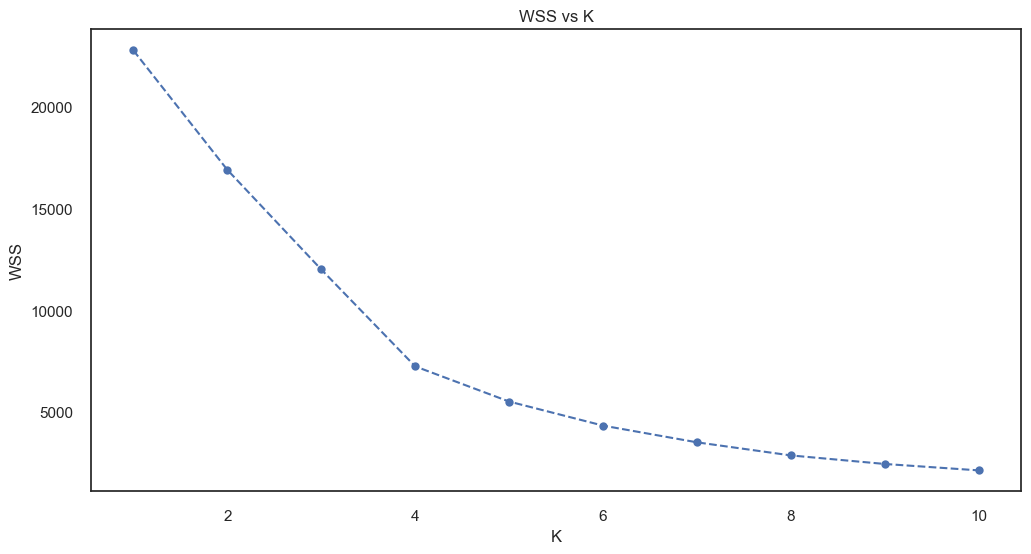

In [43]:
wss = []

for k in clusters:
    #model definition
    kmeans = c.KMeans(n_clusters=k)
    
    #model training
    kmeans.fit(X)
    
    #validation
    wss.append(kmeans.inertia_)

#plot wws - Elbow Method
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('WSS')
plt.title('WSS vs K')

## 7.2 Silhouette vs Elbow Analysis

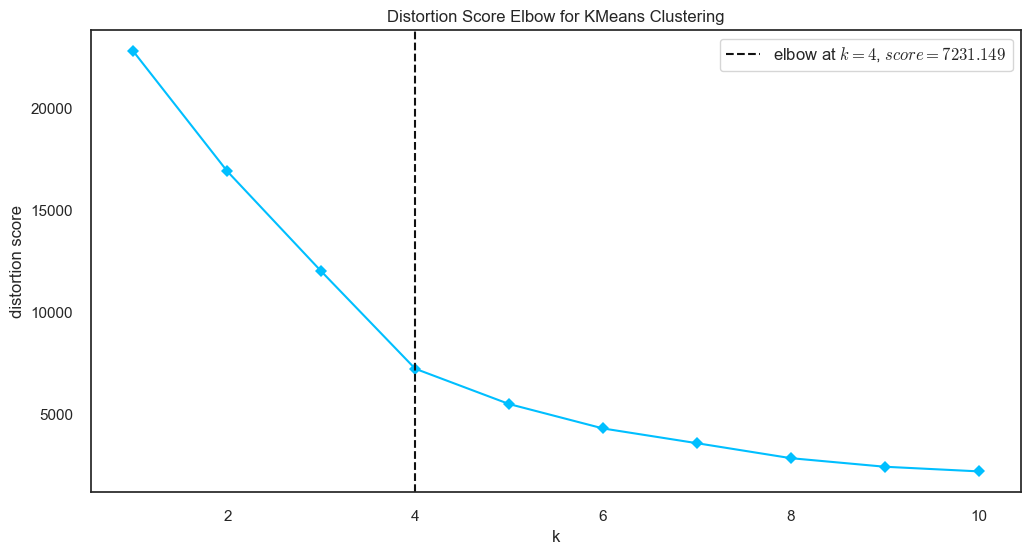

In [44]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

In [45]:
clusters = np.arange(2,11,1)

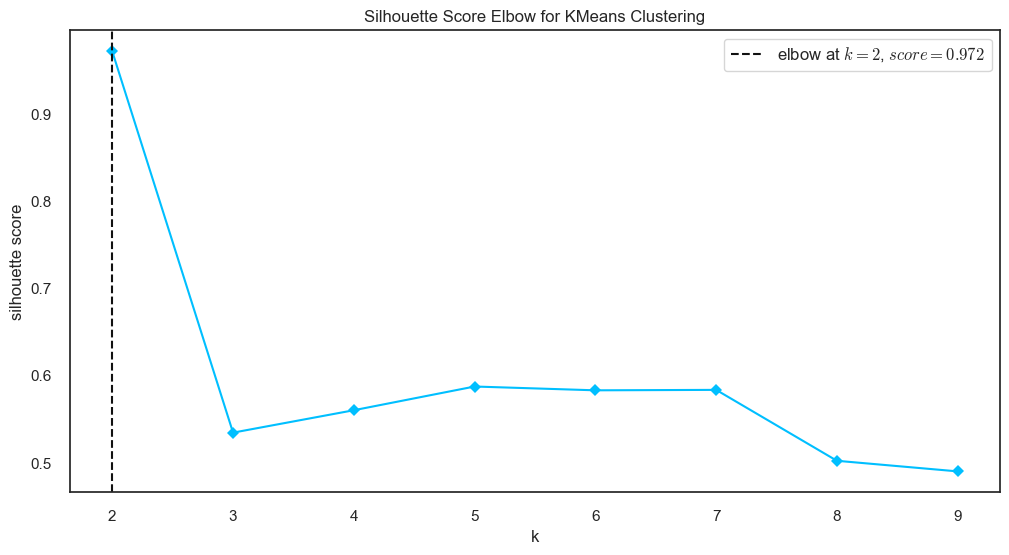

In [46]:
clusters = np.arange(2,10,1)
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False, metric='silhouette')
kmeans.fit(X)
kmeans.show();

Com a Criação de novas features, a silhouette score já deu um valor alto para 4-5 clusters, que anteriormente eram 3. Então seguirei usando 5 clusters nesse ciclo

## 7.3 Silhouette Analysis

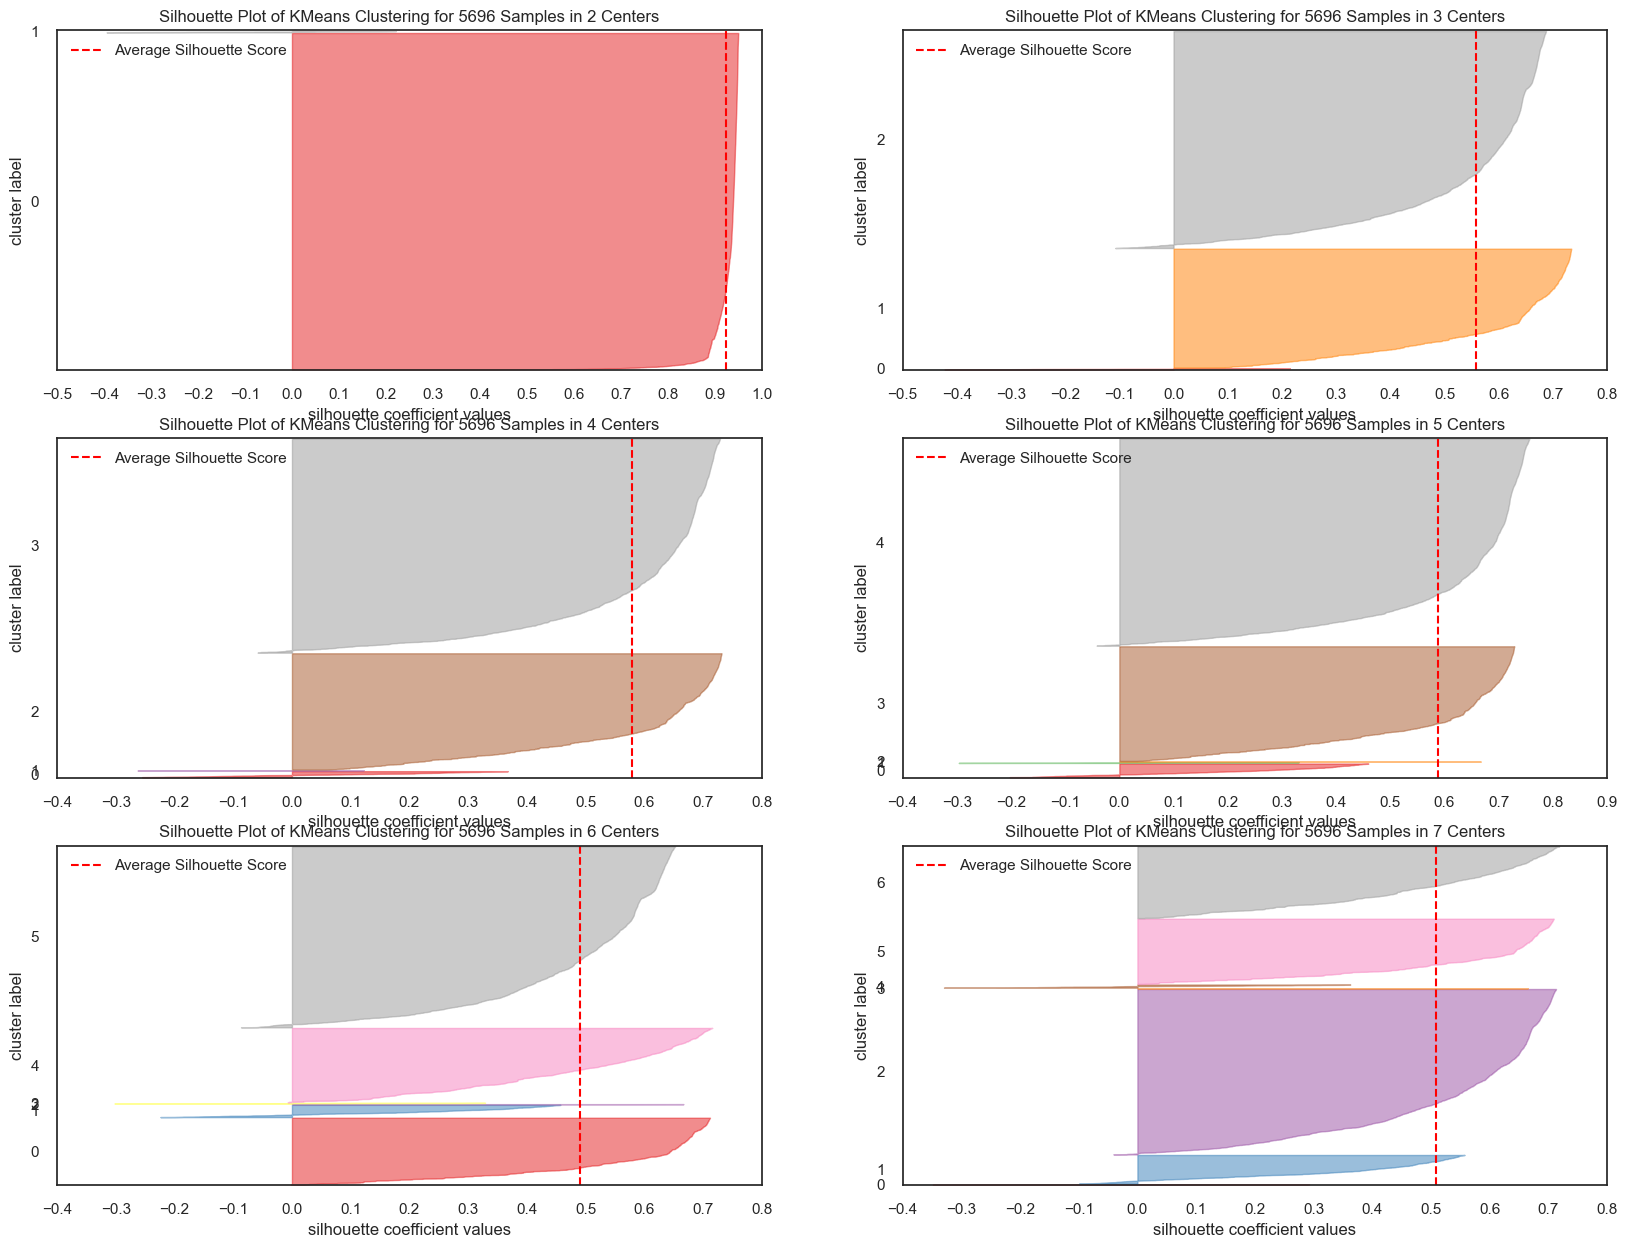

In [47]:
clusters = np.arange(2,8,1)
fig, ax = plt.subplots(3,2, figsize=(20,15))

for k in clusters:
    kmeans = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, random_state=42)
    q, mod = divmod(k,2)
    
    visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 MODEL TRAINING

## 8.1 K-Means

In [48]:
k = 5
#definition
kmeans = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, random_state=42)

#training
kmeans.fit(X)

#clusters
labels = kmeans.labels_

In [49]:
#WSS
print(f'WSS Score: {kmeans.inertia_:.3f}')

print(f'SS Score: {mt.silhouette_score(X, labels):.3f}')

WSS Score: 5499.702
SS Score: 0.588


# 9.0 CLUSTER ANALYSIS

In [50]:
df9 = df6.copy()
df9['clusters'] = labels

In [51]:
df9.head()

,customer_id,monetary,frequency,recency,ticket_medio,clusters
0,-0.574267,9.546563,-0.362740,1.864005,60.194304,2
1,-0.574262,0.317429,0.518042,-1.029288,-0.024129,4
2,-0.574258,-0.046394,0.077651,-0.375386,-0.001067,4
3,-0.574254,-0.043822,-0.362740,-0.885967,-0.026812,4
4,-0.574249,-0.191130,-0.362740,1.729642,-0.028251,3


## 9.1 Visualize Inspection

In [52]:
#px.scatter_3d(df9, x='monetary', y='recency', z='frequency', color=labels)

## 9.2 Silhouette Visualizer

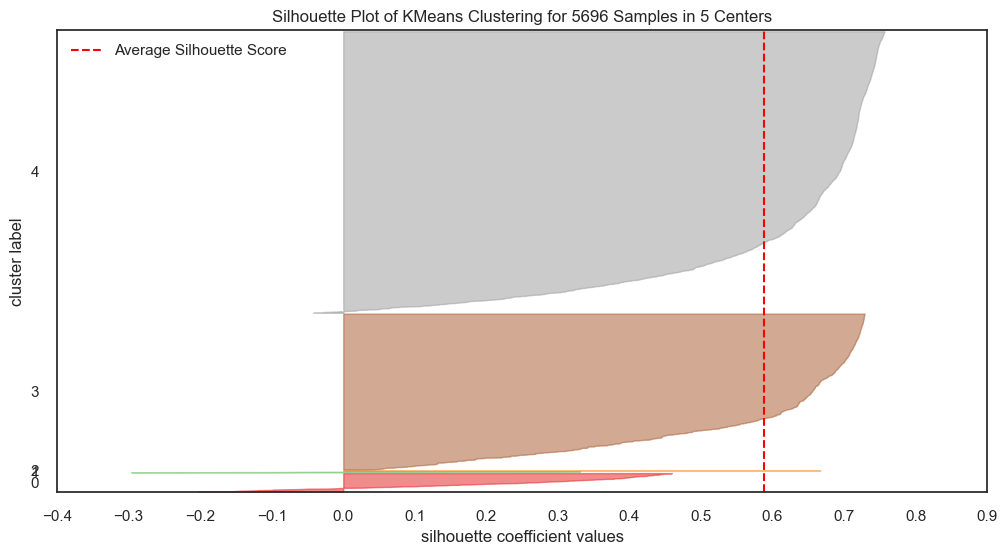

In [53]:
visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.3 2D Plot

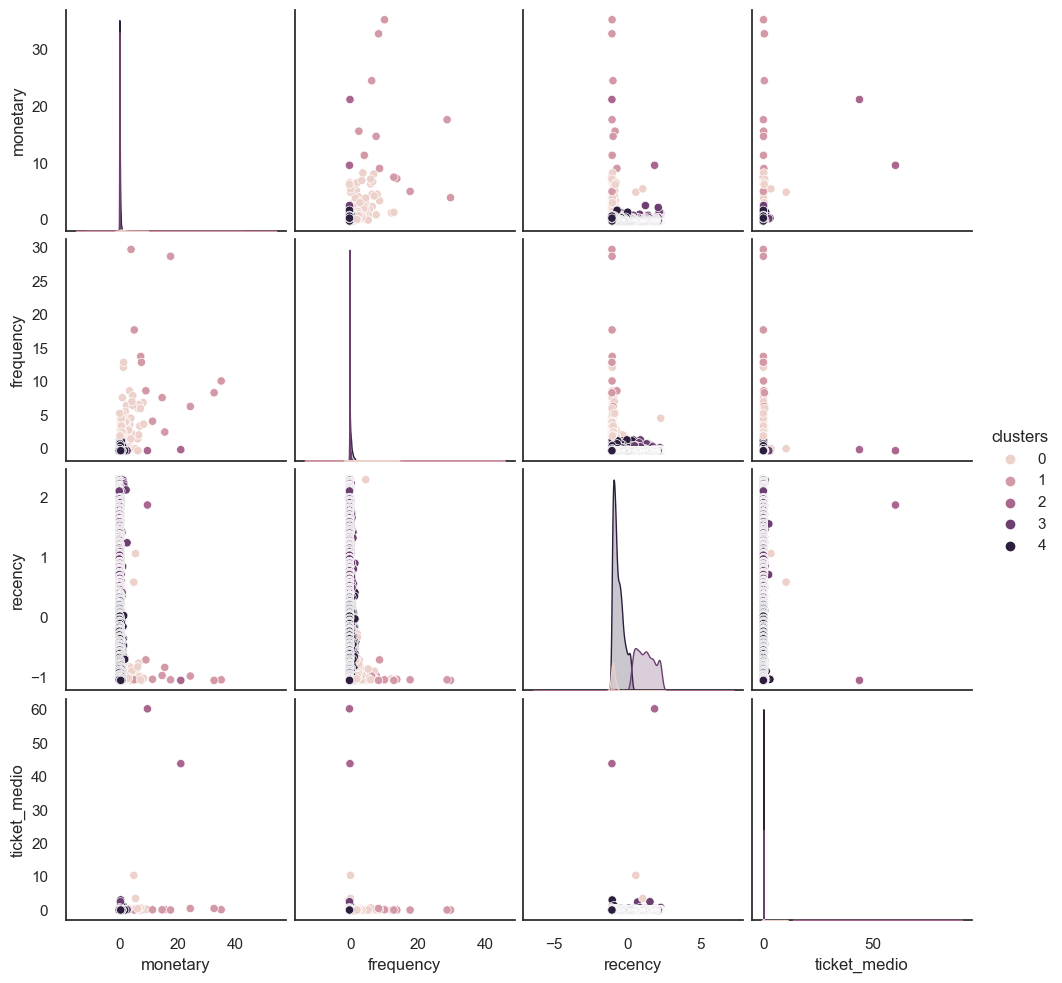

In [54]:
df_viz = df9.drop('customer_id', axis=1)
sns.pairplot(df_viz, hue='clusters')

## 9.4 UMAP - t-SNE

In [55]:
import umap.umap_ as umap

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

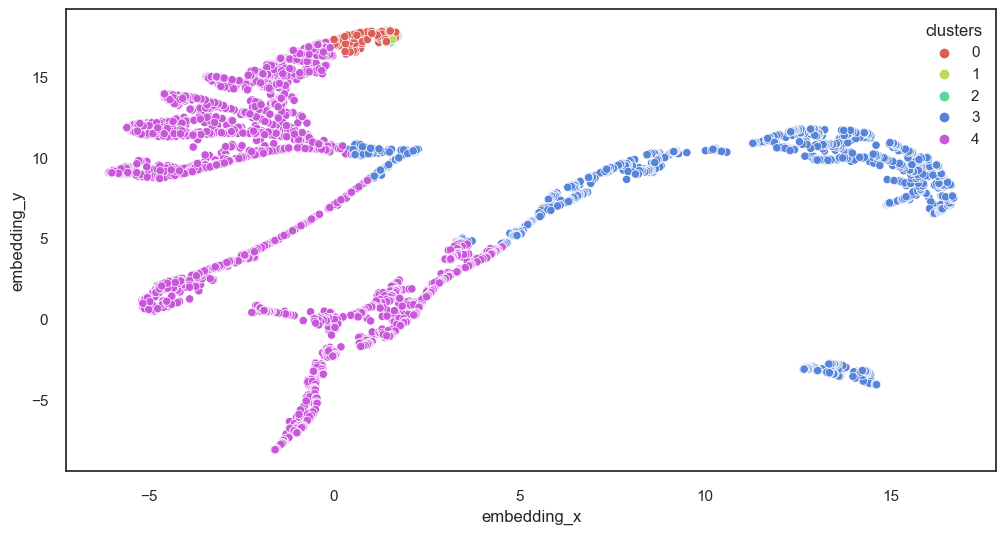

In [56]:
reducer = umap.UMAP(n_neighbors=70, random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
                hue='clusters',
                palette=sns.color_palette('hls', n_colors=len(df_viz['clusters'].unique())),
                data=df_viz)

Os Clusters estarem perto um dos outros nessa figura é um bom sinal, porque significa que na alta dimensionalidade eles tem a probabilidade de estarem próximos

## 9.5 Cluster Profile

In [57]:
#Per Monetary
df_monetary = df9.loc[:,['clusters','monetary']].groupby('clusters').mean().reset_index()

#Per Frequency
df_frequency = df9.loc[:,['clusters','frequency']].groupby('clusters').mean().reset_index()

#Per Recency
df_recency = df9.loc[:,['clusters','recency']].groupby('clusters').mean().reset_index()

#Per Pencentual
df_client_perc = df9.loc[:,['customer_id','clusters']].groupby('clusters').count().reset_index()
df_client_perc['customer_id'] = df_client_perc['customer_id'].apply(lambda x: 100*(x)/(df_client_perc['customer_id'].sum()))
df_client_perc = df_client_perc.rename(columns={'customer_id':'percent'})

#Per Ticket
df_ticket = df9.loc[:,['clusters','ticket_medio']].groupby('clusters').mean().reset_index()

df_resume = pd.merge(df_monetary, df_frequency, on='clusters', how='left').merge(df_recency, on='clusters', how='left').merge(df_client_perc, on='clusters', how='left').merge(df_ticket, on='clusters', how='left')


In [58]:
df_resume

,clusters,monetary,frequency,recency,percent,ticket_medio
0,0,1.255801,2.589723,-0.927808,4.055478,0.060344
1,1,15.312757,12.494235,-0.983007,0.210674,0.091737
2,2,15.327241,-0.289342,0.408401,0.035112,51.989534
3,3,-0.146872,-0.321867,1.237944,34.111657,-0.022467
4,4,-0.062465,-0.034832,-0.621443,61.587079,-0.021484


Cluster 0 - Clientes Esporádicos
    - Clientes que comprar pouco, valor baixo, e com uma média de 3 meses. Porém engloba 99% dos clientes
    
Cluster 1 - Clientes Medianos
    - Clientes que compram em média uma vez por mês mas uma quantia maior e um valor maior que os Esporádicos
    
Cluster 2 - Clientes elegíveis a Insiders
    - Gastam muito, toda semana e compram bastante produtos

# 10.0 DEPLOY 